# FIRST ROUND OF CHECKS

This round of checks is for each of the experiment conditions


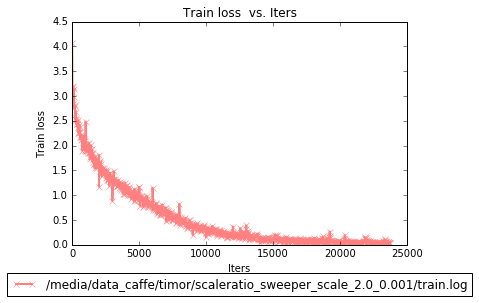

In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py

%load_ext autotime


this_exp='/media/data_caffe/timor/scaleratio_sweeper_scale_2.0_0.001/' #change this for each experiment 
region='timor'
scale_method='scale'
scale_factor='2.0'


## CHECK LOSS 
os.chdir('/home/caffe/gits')
import catlin_deeplearning.tools.catlin_caffe_tools as cct
import catlin_deeplearning.beijbom.plot_log as pl
import catlin_deeplearning.tools.catlin_tools as ct
#HERE you want to check that the loss/iteration plot reaches a plateau
% matplotlib inline
pl.plot_chart(6, '~/temp.png', [this_exp+'train.log'])

## CHECK ACCURACY ON VALIDATION SET 

Here you want to check that the accuracy reached plateau with the iterations. If these two conditions are not met, consider increasing number of iterations


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
best itt: 7000


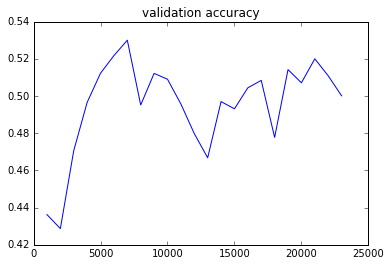

time: 31.5 s


In [2]:
%load_ext autotime
bestitt, dd = cct.find_best_iter(this_exp)
plt.plot([d[0] for d in dd], [d[1] for d in dd])
plt.title('validation accuracy')
print 'best itt: {}'.format(bestitt)

## PREDICT ON TEST IMAGES

NOTES: 
    /This is specific for each experiment condition. 
    /This will use the graphic card, so make sure that the machine is not in use 

In [3]:
%load_ext autotime
import catlin_deeplearning.tools.catlin_caffe_tools as cct
workdir=this_exp
gpuid=0
Split='test'
# find and load optimal model
#bestiter, _ = cct.find_best_iter(workdir)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.53 ms


In [4]:
# load test-data and write split
labelset=ct.get_labelset(region)
imlist, imdict = ct.load_data(Split,labelset,region)
im_mean = bct.calculate_image_mean(imlist[::10])
#ct.write_split(workdir, region, Split, labelset,scale_method,scale_factor)


[  97.73119464  108.80099879  104.39736229]
time: 5.87 s


In [5]:
caffemodel = 'snapshot_iter_{}.caffemodel'.format(bestitt)
net = bct.load_model(workdir, caffemodel, gpuid = gpuid, net_prototxt = 'trainnet.prototxt')
pyparams = pload(osp.join(workdir, 'trainpyparams.pkl'))

DataLayer initialized with 456 images, 5 imgs per batch, and 224x224 pixel patches
time: 14.1 s


In [6]:
# run on test-data
(gtlist, estlist, scorelist) = bct.classify_from_patchlist(imlist, imdict, pyparams, net)
psave((gtlist, estlist, scorelist), osp.join(workdir, 'predictions_on_test.p'))

time: 7min 25s


## PRINT CONFUSION MATRIX FOR EXPERIMENT CONDITION

#### IN FULL

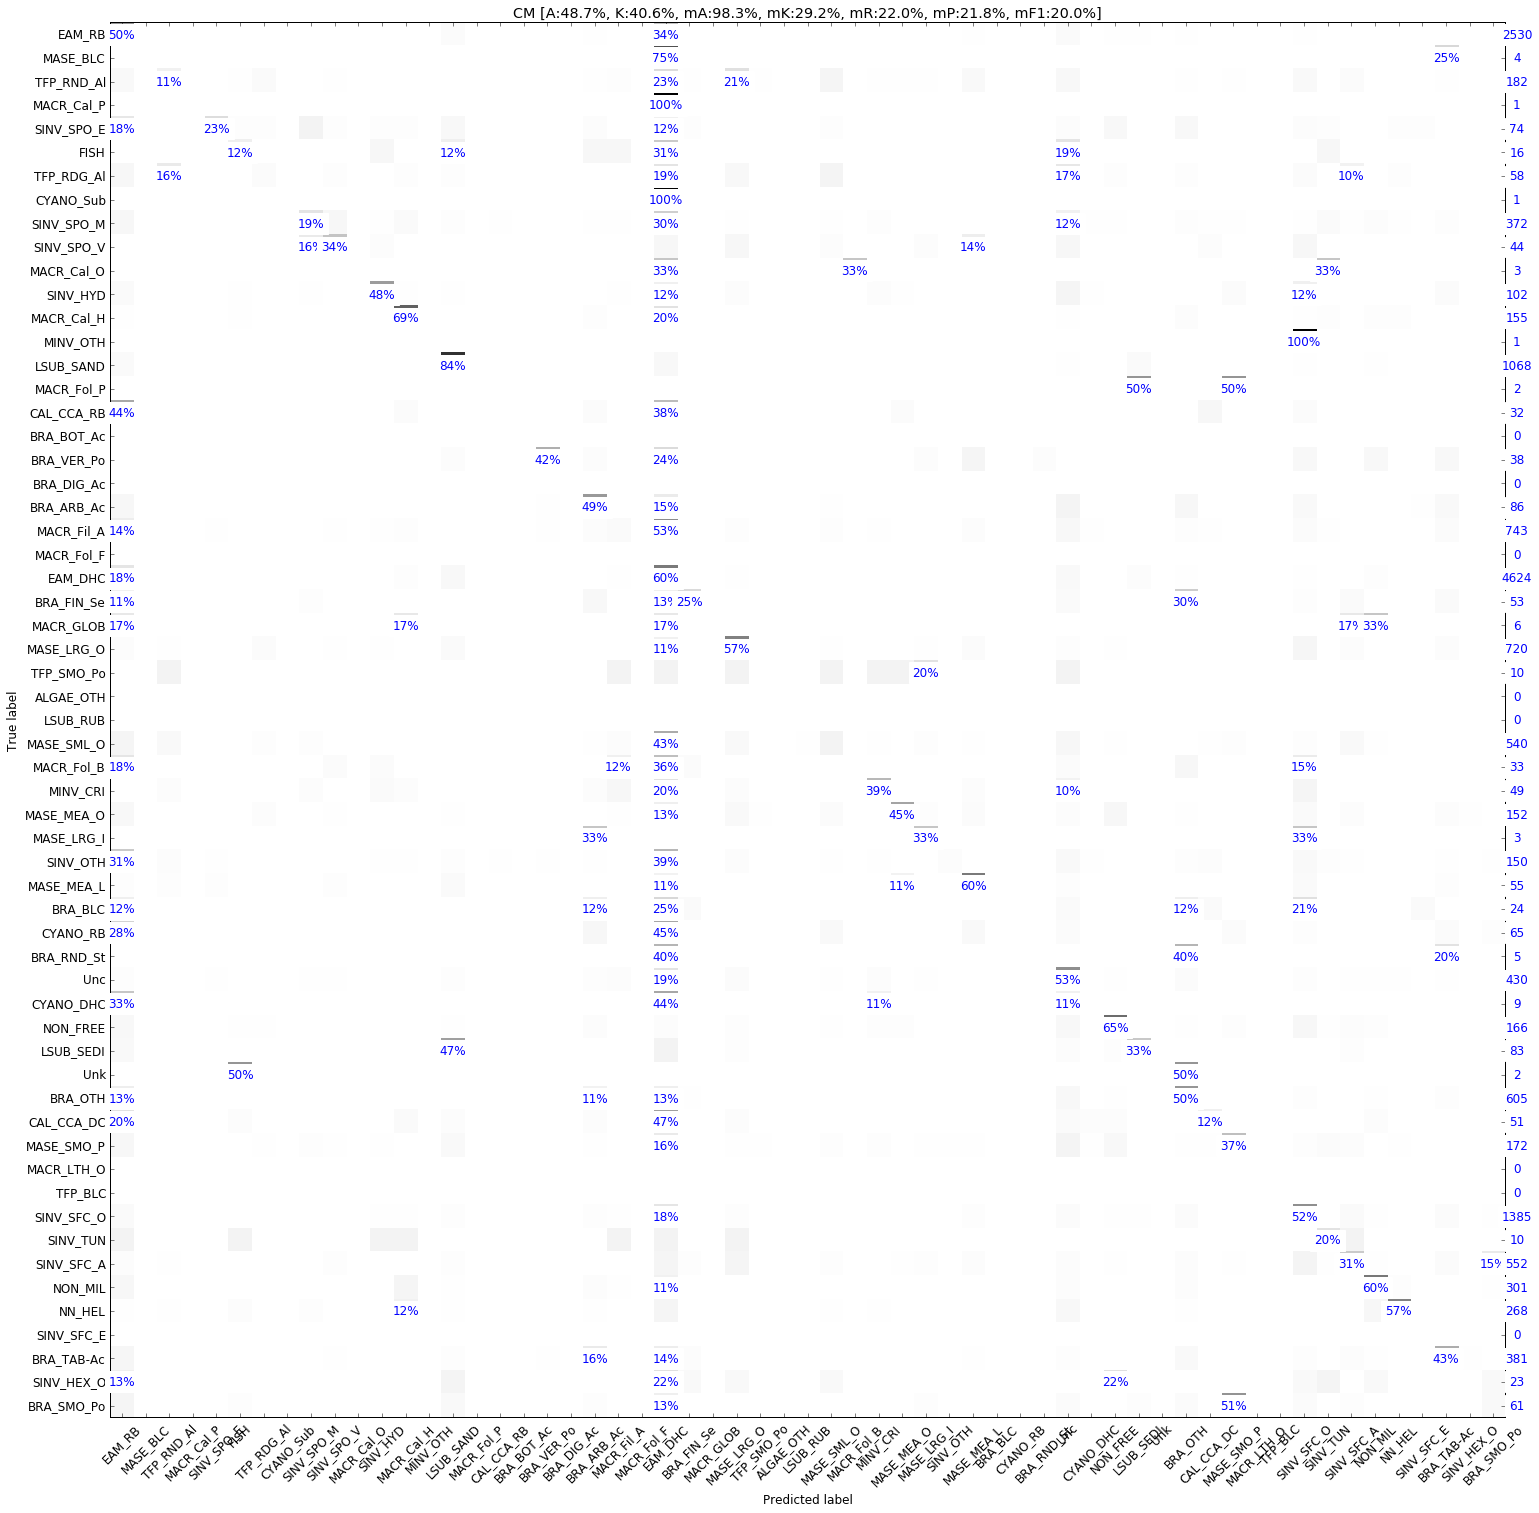

time: 1.87 s


In [8]:
%matplotlib inline
(gtlist, estlist, scorelist) = pload(this_exp+'/predictions_on_test.p')
plt.rcParams['figure.figsize'] = 25, 25
cm = confmatrix.ConfMatrix(len(labelset), labelset = labelset)
cm.add(gtlist, estlist)
cm.show(threshold = 10, fontsize=12)

#### FUNCTIONAL GROUPS OR OTHER COLLAPSING TIERS 

['coral', 'Non hermatypic', 'soft-coral', 'sponge', 'Other Invertebrates', 'Algae', 'Sediment', 'Other']


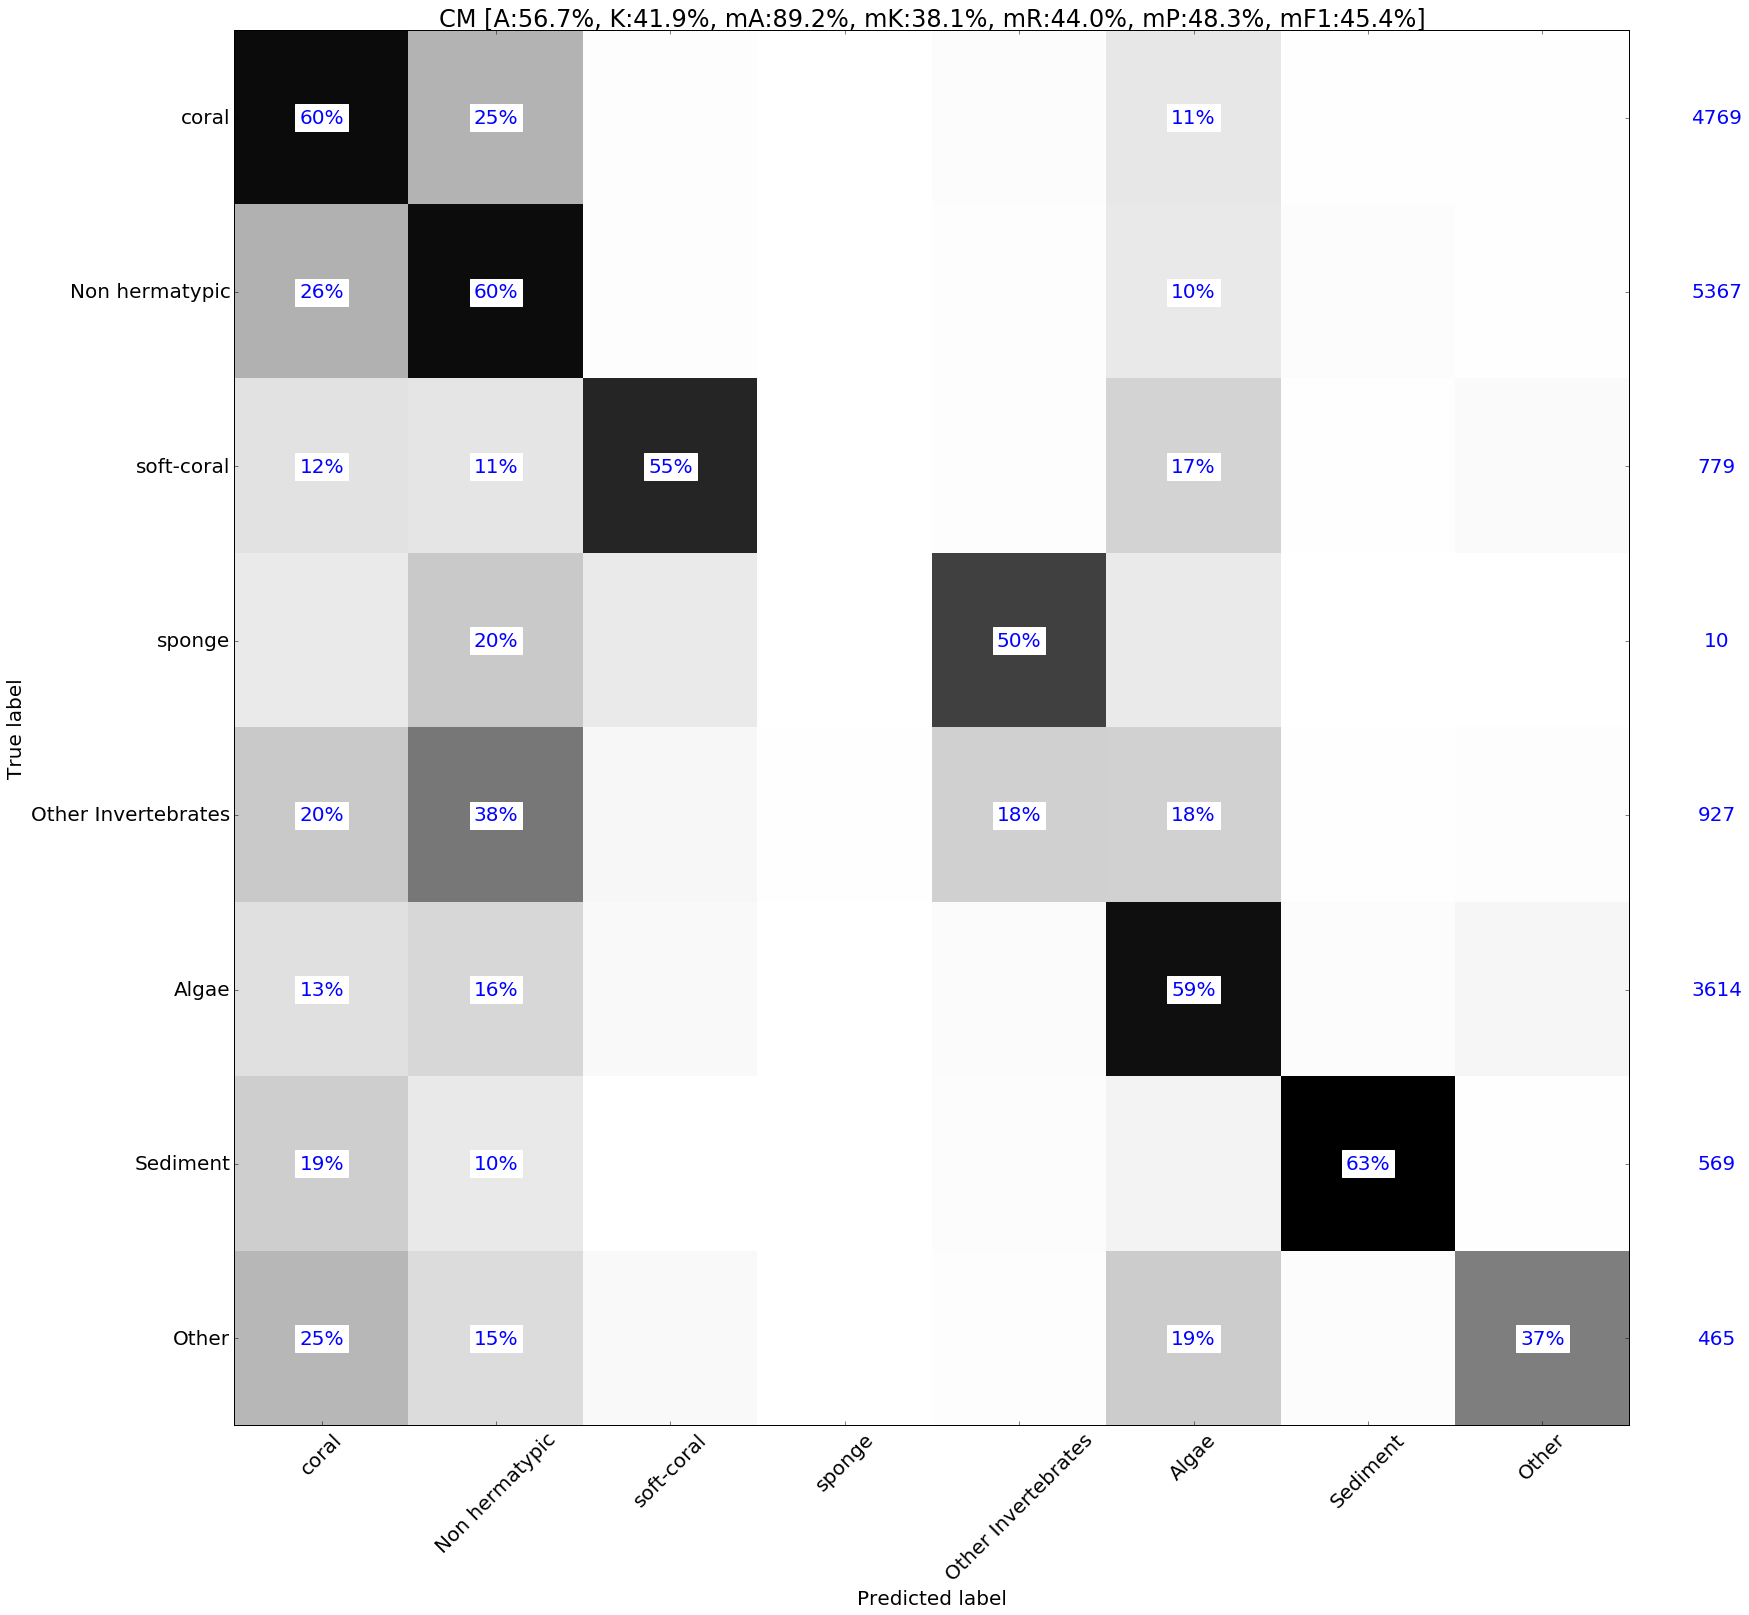

time: 574 ms


In [9]:
## READ LABELSET AND COLLAPSE CM
from collections import defaultdict
from itertools import count
from functools import partial

## define collapsing tier by column number
ct=2 ##CHANGE THIS

lines = [line.rstrip() for line in open('/media/data_caffe/'+region+'/label_structure.csv')][1:]
labels= [line.split(',')[ct] for line in lines]
label_to_number = defaultdict(partial(next, count(0)))
cmap=[(label_to_number[label],label) for label in labels]
collapsemap=[int(i[0]) for i in cmap]
collapsemap=np.array(map(int, collapsemap))
##COLLAPSE CM
cmc=cm.collapse(collapsemap)
cmap=set(cmap)
cmap = sorted(list(cmap), key=lambda tup: tup[0])
labelsetc = [str(i[1]) for i in cmap]
cm2= confmatrix.ConfMatrix(len(labelsetc), labelset = labelsetc)
print(labelsetc)
for x in range(cmc.shape[0]):
    for y in range(cmc.shape[1]):
        cm2.cm[x,y]=cmc[x,y]
        
##PLOT COLLAPSED CM
%matplotlib inline    
plt.rcParams['figure.figsize'] = 25, 25
cm2.show(threshold = 10, fontsize=20)